In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

%pip install rasterio
%pip install imageio
%pip install fiona
%pip install geopandas
%pip install earthpy
%pip install Pillow
%pip install gdal
%pip install tifffile
%pip install imagecodecs

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 36.7 MB/s eta 0:00:00


In [2]:
import imageio
import rasterio
from rasterio.plot import show
from rasterio.transform import from_origin
from rasterio.coords import disjoint_bounds
from rasterio.windows import from_bounds
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio import mask
from rasterio.features import geometry_mask
from rasterio import features
from rasterio.enums import MergeAlg

from rasterio.warp import calculate_default_transform, reproject, Resampling
import pyproj

import geopandas as gpd

from osgeo import gdal
import matplotlib.pyplot as mplot
import numpy as np
from numpy import int16

from PIL import Image

import cv2
import numpy as np
from google.colab.patches import cv2_imshow

import fiona
import geopandas as gpd
from shapely.geometry import box

import os
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.plot as ep

import math
import shutil
import gc

Spatial join of shapes and classification points



In [3]:
root_dir = "gdrive/My Drive/Stage/Data/Input/Train"

shapepaths = sorted([f for f in os.listdir(os.path.join(root_dir, "Shapes")) if f.endswith('.shp')])
pointpaths = sorted([f for f in os.listdir(os.path.join(root_dir, "Points")) if f.endswith('.shp')])

# Store in lists
all_soorten = []
soorten = []
gdfs = []

for shapepath, pointpath in zip(shapepaths, pointpaths):
    gdf_shapes = gpd.read_file(os.path.join(root_dir, "Shapes", shapepath))
    gdf_points = gpd.read_file(os.path.join(root_dir, "Points", pointpath))

    # Assuming bird species is stored in "soort", "soort_gedrag" or "soort_gedr" column
    if "soort" in gdf_points:
      all_soorten.append(gdf_points["soort"].unique().tolist())
      gdf_points["soort"] = gdf_points["soort"].str.split(" - ").str[0] # Remove "-..." from string (broedend, rustend, etc.)
    elif "soort_gedrag" in gdf_points:
      all_soorten.append(gdf_points["soort_gedrag"].unique().tolist())
      gdf_points["soort"] = gdf_points["soort_gedrag"].str.split(" - ").str[0]
    elif "soort_gedr" in gdf_points:
      all_soorten.append(gdf_points["soort_gedr"].unique().tolist())
      gdf_points["soort"] = gdf_points["soort_gedr"].str.split(" - ").str[0]

    # Perform spatial join (points that do not overlap with a polygon are omitted)
    merged = gpd.sjoin(gdf_shapes, gdf_points, how='left', predicate='contains')

    # Remove
    merged = merged.dropna(subset=['soort']) # nan
    merged = merged[~merged.soort.str.contains("dood")] # dood
    # merged = merged[~merged.soort.str.contains("anders")] # anders (maybe keep)
    soorten.append(merged["soort"].unique().tolist())

    # Append merged
    gdfs.append(merged)

# Soorten were appended as numpy array, so convert to list, unlist nested lists and list only unique soorten
all_soorten = list(set([item for sublist in all_soorten for item in sublist]))
soorten = list(set([item for sublist in soorten for item in sublist]))

# Print
print(all_soorten)
print("We will continue with:", soorten)

['kokmeeuw - broedend', 'zwartkopmeeuw - broedend', 'zwartkopmeeuw - rustend', 'grote stern - niet broedend', 'grote stern - dood', 'grote stern - broedend (opgevlogen)', 'anders', 'grote stern - broedend', 'grote stern dood', 'grote stern', 'visdief - broedend', 'visdief - niet broedend', 'grote stern - rustend', 'canadese gans - broedend', 'kokmeeuw - rustend', 'kokmeeuw - niet broedend', 'visdief - rustend', 'kokmeeuw']
We will continue with: ['zwartkopmeeuw', 'kokmeeuw', 'visdief', 'grote stern']


#### From joined shapes



*   Reproject and make shape rasters
*   Convert to images





In [5]:
# List rasters
rasterpaths = sorted([f for f in os.listdir(os.path.join(root_dir, "Rasters")) if f.endswith('.tif')])

# Assuming rasters, shapes, points have same naming convention
# Because of sizes, you may not have all rasters uploaded
# Therefore, loop only over gdfs that have a corresponding raster, for this find index

index_list = []
for rasterpath in rasterpaths:
  rastername = rasterpath[:-4] # without .tif extension
  index = next((index for index, item in enumerate(shapepaths) if rastername in item), None)
  index_list.append(index)

for index, rasterpath in zip(index_list, rasterpaths):

    gdf = gdfs[index] # load corresponding gdf

    with rasterio.open(os.path.join(root_dir, "Rasters", rasterpath)) as src:

        # Get the CRS of the shapefile
        target_crs = gdf.crs

        # ---------------------------------------------------------------- #
        # Reproject the raster to match the CRS of the shapefile
        # ---------------------------------------------------------------- #
        transform, width, height = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        os.makedirs(os.path.join(root_dir, "Rasters/Reprojected"), exist_ok=True) # Save reprojected rasters in 'Reprojected' folder
        with rasterio.open(os.path.join(root_dir, "Rasters/Reprojected", rasterpath), 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest
                )

        # Load reprojected raster
        dst = rasterio.open(os.path.join(root_dir, "Rasters/Reprojected", rasterpath))

        del src
        gc.collect()

        # ---------------------------------------------------------------- #
        # Create a new shape raster
        # ---------------------------------------------------------------- #
        # Generate masks based on the species
        n = 1 # Give species raster values starting from 1

        soort_raster = np.zeros_like(dst.read(1)) # 0 will mean there is no bird

        for soort in soorten:

            # Check if soort exists within the shapes
            if soort in gdf['soort'].values:

                # Generate mask
                mask = geometry_mask(gdf[gdf['soort'] == soort].geometry, out_shape=dst.shape, transform=dst.transform, invert=True)

                # Set value
                soort_raster[mask] = n
            else:
                pass # raster is not updated as soort was not found

            n = n + 1

        # Save the new raster
        os.makedirs(os.path.join(root_dir, "ShapeRasters"), exist_ok=True) # Save new raster in 'ShapeRasters' folder
        profile = dst.profile
        profile.update(count=1, dtype='uint8', nodata=None)  # Remove nodata value
        with rasterio.open(os.path.join(root_dir, "ShapeRasters", rasterpath), 'w', **profile) as newr:
            newr.write(soort_raster.astype('uint8'), 1)

        # Load shape raster
        newr = rasterio.open(os.path.join(root_dir, "ShapeRasters", rasterpath))

        # The shape raster may be too big, if so make it smaller
        src1 = dst # raster file
        src2 = newr # shape raster file

        # Get the window that covers the extent of src1
        window = src2.window(*src1.bounds)

        # Read the data for the overlapping area from src2
        data2 = src2.read(window=window)

        # Update metadata for the clipped raster
        clipped_meta = src2.meta.copy()
        clipped_meta.update({
            'height': data2.shape[1],
            'width': data2.shape[2],
            'transform': src1.window_transform(window)  # Update the transform to match the new window
        })

        # Overwrite
        with rasterio.open(os.path.join(root_dir, "ShapeRasters", rasterpath), 'w', **clipped_meta) as dst:
            dst.write(data2)

        # # Save reprojected raster as image
        # os.makedirs(os.path.join(root_dir, "Images"), exist_ok=True) # Save in 'Images' folder, and 'Reprojected' and 'Shapes' subfolders
        # os.makedirs(os.path.join(root_dir, "Images/Reprojected"), exist_ok=True)
        # os.makedirs(os.path.join(root_dir, "Images/Shapes"), exist_ok=True)

        del dst, newr


In [ ]:
# List rasters
rasterpaths = sorted([f for f in os.listdir(os.path.join(root_dir, "Rasters")) if f.endswith('.tif')])

for rasterpath in rasterpaths:

    # ---------------------------------------------------------------- #
    # Save as images
    # ---------------------------------------------------------------- #
    # Load in GDAL
    raster_data_set = gdal.Open(os.path.join(root_dir, "Rasters/Reprojected", rasterpath))
    mask_data_set = gdal.Open(os.path.join(root_dir, "ShapeRasters", rasterpath))

    # Convert to array image
    raster_band_1 = raster_data_set.GetRasterBand(1) # red channel
    raster_band_2 = raster_data_set.GetRasterBand(2) # green channel
    raster_band_3 = raster_data_set.GetRasterBand(3) # blue channel
    mask_band_1 = mask_data_set.GetRasterBand(1) # first/only channel

    # del raster_data_set, mask_data_set

    # Convert to array image
    raster_b1 = raster_band_1.ReadAsArray()
    raster_b2 = raster_band_2.ReadAsArray()
    raster_b3 = raster_band_3.ReadAsArray()
    mask_b1 = mask_band_1.ReadAsArray()

    # Stack to image
    raster_img = np.dstack((raster_b1, raster_b2, raster_b3))
    mask_img = np.dstack((mask_b1))
    mask_img = mask_img[0].T # Transpose because axis was inverted (why?)

    # ---------------------------------------------------------------- #
    # Save
    # ---------------------------------------------------------------- #
    os.makedirs(os.path.join(root_dir, "Images"), exist_ok=True) # Save in 'Images' folder, and 'Reprojected' and 'Shapes' subfolders
    os.makedirs(os.path.join(root_dir, "Images/Reprojected"), exist_ok=True)
    os.makedirs(os.path.join(root_dir, "Images/Shapes"), exist_ok=True)

    plt.imsave(os.path.join(root_dir, "Images/Reprojected", rasterpath[:-4]+".png"), raster_img.astype(np.uint8), cmap='gray', format='png') # Convert to uint8
    plt.imsave(os.path.join(root_dir, "Images/Shapes", rasterpath[:-4]+"_mask.png"), mask_img.astype(np.uint8), cmap='gray', format='png') # Convert to uint8

    # Delete Reprojected and ShapeRasters folders for memory
    shutil.rmtree(os.path.join(root_dir, "Rasters/Reprojected"))
    shutil.rmtree(os.path.join(root_dir, "ShapeRasters"))

## Tile

In [3]:
# One at a time to save memory (may need to restart runtime)

root_dir = "gdrive/My Drive/Stage/Data/Input/Train"

rname = "Texel_DePetten_2022_vlucht1.tif"
imgpath = os.path.join(root_dir, "Rasters/Reprojected", rname)
maskpath = os.path.join(root_dir, "ShapeRasters", rname)

# Open with GDAL
raster_data_set = gdal.Open(imgpath)
mask_data_set = gdal.Open(maskpath)

# Convert to array image
raster_band_1 = raster_data_set.GetRasterBand(1) # red channel
raster_band_2 = raster_data_set.GetRasterBand(2) # green channel
raster_band_3 = raster_data_set.GetRasterBand(3) # blue channel
mask_band_1 = mask_data_set.GetRasterBand(1) # first/only channel

# Convert to array image
raster_b1 = raster_band_1.ReadAsArray()
raster_b2 = raster_band_2.ReadAsArray()
raster_b3 = raster_band_3.ReadAsArray()
mask_b1 = mask_band_1.ReadAsArray()

# Stack to image
raster_img = np.dstack((raster_b1, raster_b2, raster_b3))
mask_img = np.dstack((mask_b1))
mask_img = mask_img[0].T # Transpose because axis was inverted (why?)


In [4]:
# WxH tile pixel size
W = 750
H = 750

# Split in to M and N tiles
raster_tiles = [raster_img[x:x+W,y:y+H] for x in range(0,raster_img.shape[0],W) for y in range(0,raster_img.shape[1],H)]
mask_tiles = [mask_img[x:x+W,y:y+H] for x in range(0,mask_img.shape[0],W) for y in range(0,mask_img.shape[1],H)]

print("Total tiles:", len(raster_tiles))

Total tiles: 1242


#### Remove % tiles with no birds

In [5]:
import random

# # Remove tiles with NoData (black borders)
# for i in range(len(raster_tiles)):

#   # Value 0 = black (but sometimes < 0  or > 256)
#   if (raster_tiles[i] == 0).any() or (raster_tiles[i] < 0).any() or (raster_tiles[i] > 256).any():
#     raster_tiles[i] = None
#     mask_tiles[i] = None

# Filter
# raster_tiles = [tile for tile in raster_tiles if tile is not None]
# mask_tiles = [tile for tile in mask_tiles if tile is not None]

# Filter based on tiles where there are no masks (birds)
bird_raster_tiles = []
bird_mask_tiles = []
no_bird_raster_tiles = []
no_bird_mask_tiles = []

for i in range(len(raster_tiles)):

  mask_tile_img = mask_tiles[i].copy()
  contours, _ = cv2.findContours(mask_tile_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if contours == ():
    no_bird_raster_tiles.append(raster_tiles[i])
    no_bird_mask_tiles.append(mask_tiles[i])

  else:
    bird_raster_tiles.append(raster_tiles[i])
    bird_mask_tiles.append(mask_tiles[i])

# Filter a percentage of the no bird tiles (to reduce dataset)
keep_percentage = 1
remove_count = len(no_bird_raster_tiles) * (100 - keep_percentage) // 100
indices_to_remove = random.sample(range(len(no_bird_raster_tiles)), remove_count)
no_bird_raster_tiles = [item for i, item in enumerate(no_bird_raster_tiles) if i not in indices_to_remove]
no_bird_mask_tiles = [item for i, item in enumerate(no_bird_mask_tiles) if i not in indices_to_remove]

# Concat and shuffle
raster_tiles = bird_raster_tiles + no_bird_raster_tiles
mask_tiles = bird_mask_tiles + no_bird_mask_tiles

def shuffle_similarly(list1, list2):
    combined = list(zip(list1, list2))
    random.shuffle(combined)
    shuffled_list1, shuffled_list2 = zip(*combined)
    return list(shuffled_list1), list(shuffled_list2)

raster_tiles, mask_tiles = shuffle_similarly(raster_tiles, mask_tiles)

print("After filtering", len(raster_tiles), "tiles")

# If too many, use only certain fraction
# raster_tiles = raster_tiles[:int(len(raster_tiles) * 0.1)]
# mask_tiles = mask_tiles[:int(len(mask_tiles) * 0.1)]
# print("Using", len(raster_tiles), "tiles")


After filtering 80 tiles


61
[0 4]


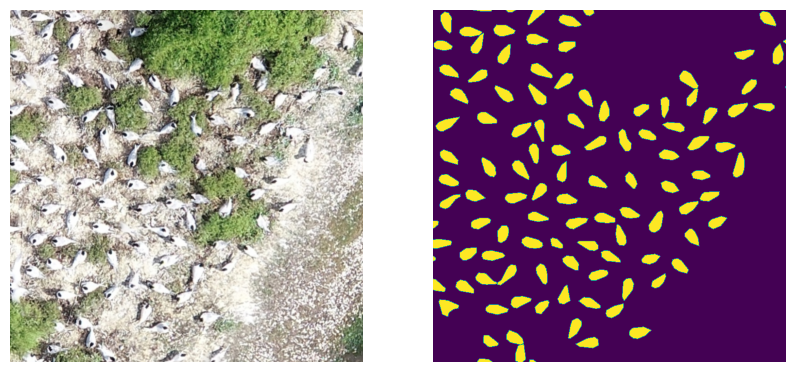

In [11]:
# Check if raster and mask tiles correspond / make sense
import random

# Create a figure with two subplots arranged in a 1x2 grid
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# See random tile
tile_numb = random.randint(0, len(raster_tiles)-1)
print(tile_numb)

# Plot the images
axs[0].imshow(raster_tiles[tile_numb].astype(np.uint8))
axs[0].axis('off')  # Turn off axis labels and ticks
axs[1].imshow(mask_tiles[tile_numb].astype(np.uint8))
axs[1].axis('off')

# Print unique mask values (soorten)
unique_values_mask = np.unique(mask_tiles[tile_numb])
print(unique_values_mask)

# Colours are not specific to one class (e.g., yellow can mean class A in image 1, class B in image 2)

## Write images, masks and annotations to file

In [34]:
# For each tile, write to file and create annotations

# Out paths
out_img_path = "gdrive/My Drive/Stage/ClassificationData/Ready/Images/"
out_mask_path = "gdrive/My Drive/Stage/ClassificationData/Ready/Masks/"
out_anno_path = "gdrive/My Drive/Stage/ClassificationData/Ready/Annotations/"
rastername = rname[:-4] # pass raster name as identifier

for i in range(len(raster_tiles)):

  # Output path
  out_img = out_img_path + rastername + "_img" + str(i+1) + ".png"
  out_mask = out_mask_path + rastername + "_mask" + str(i+1) + ".png"
  out_ann = out_anno_path + rastername + "_annotation" + str(i+1) + ".txt"

  # Save images to file
  plt.imsave(out_img, raster_tiles[i].astype(np.uint8), cmap='gray', format='png') # Convert to uint8
  plt.imsave(out_mask, mask_tiles[i].astype(np.uint8), cmap='gray', format='png')

  # Calculate boxes from mask
  mask_tile_img = mask_tiles[i].copy()
  contours, _ = cv2.findContours(mask_tile_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  bird_labels = []  # List to store bird labels corresponding to each contour

  for contour in contours:
    # Find the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Extract the region of interest (ROI)
    roi = mask_tile_img[y:y+h, x:x+w]

    # Find the unique values and their counts in the ROI
    unique_values, counts = np.unique(roi, return_counts=True)

    # Exclude 0 from consideration (is background)
    counts = counts[unique_values != 0]
    unique_values = unique_values[unique_values != 0]

    # Get the index of the maximum count (majority value) --> necessary in cases of overlap
    majority_index = np.argmax(counts)

    # Assign the majority value
    bird_label = unique_values[majority_index]
    bird_labels.append(bird_label)

  # Image width and height
  img_colour = Image.open(out_img) # You need to have the colour image somehow (so write image to file first)
  width, height = img_colour.size

  # Class and number of objects
  num_objects = len(contours)

  with open(out_ann, 'w') as f:
      # Write annotation to file
      f.write(f'Image filename : "{out_img}"\n')
      f.write(f'Image size (X x Y) : {width} x {height}\n')
      f.write(f'Database : "BirdsBreeding"\n')
      f.write(f'Objects with ground truth : {num_objects} \n\n')

      # Loop over each bird (if any) and label
      for j, contour in enumerate(contours):
          x, y, w, h = cv2.boundingRect(contour)
          x_min = x
          y_min = y
          x_max = x + w
          y_max = y + h

          # Bird species stored in "soorten", assign species based on value
          for z, soort in enumerate(soorten):
            if bird_labels[j] == z+1: # Python indexing starts at 0, whereas we assigned raster values from 1 (0 is no bird)
                class_name = soort
            else:
              pass

          f.write(f'# Details for object {j+1} \n')
          f.write(f'Original label for object {j+1} : "{class_name}" \n')
          f.write(f'Bounding box for object {j+1} : (Xmin, Ymin) - (Xmax, Ymax) : ({x_min}, {y_min}) - ({x_max}, {y_max})\n')
          f.write(f'Pixel mask for object {j+1} : "{out_mask}"\n\n')
